# generalized case
See overleaf file for formulation 

In [1]:
import numpy as np
import matplotlib.pyplot as plt

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(0.0, 50.0)

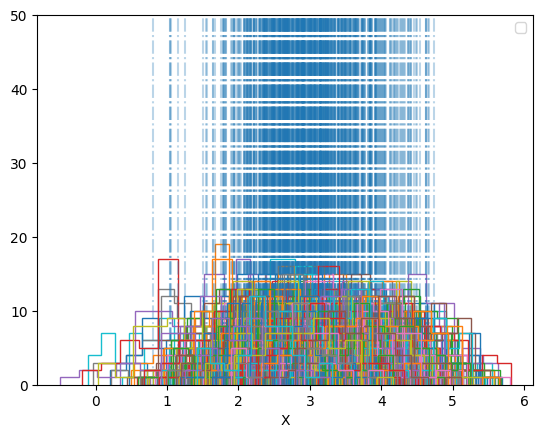

In [2]:
# True parameters for the parent + child Gaussian distribution

true_parent_mean = 3.0 # hyperparameter
true_parent_scale = .5 # hyperparameter

true_child_scale = 0.5

N_obs = 500
size_child = 50

# Hypothesis for parent gaussian 
## draws from parent  for mu child
true_parent_gaussian = np.random.normal(loc=true_parent_mean, scale=true_parent_scale, size=N_obs)

# Add scatter on the child mean because the data for a signal is signal + noise
err_on_mean_child = np.expand_dims(np.random.randn(N_obs)*true_child_scale, axis=1)
true_child_gaussian = np.random.normal(loc=true_parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

for i in range(N_obs):
    plt.hist(true_child_gaussian[i], fill=False, histtype='step')
    plt.vlines(np.mean(true_child_gaussian[i]), 0, size_child, linestyles='-.', alpha=0.3)
#plt.hist(true_parent_gaussian, fill=False, histtype='step', color='black',linewidth=3, label='hyper gaussian')
plt.xlabel("X")
plt.legend()
plt.ylim(0,size_child)

In [3]:
def log_hyperprior(params):
    parent_mean, parent_scale = params
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 1):
        return 0.0
    return -np.inf

def log_likelihood(params):
    parent_mean, parent_scale = params
    samples_mu_child = true_child_gaussian # this has to be the true value whic has to be passed as in the observed value

    ##  \frac{1}{N_i} \sum_{j=1}^{N_i} \frac{1}{\sqrt{2\pi\sigma_p^2}} \exp(-\frac{(\mu_i^j-\mu_p)^2}{2\sigma_p^2})

    # likelihood = 1
    # for samples in samples_mu_child:
    #     this_L = np.mean((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples-parent_mean)**2 / (2 * parent_scale**2)))
    #     #mean = sum/size_child
    #     likelihood *= this_L
    
    ## These two lines represent what above loop does
    #mean = size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)
    #likelihood = np.prod(mean)
    
    return np.log(np.prod(size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(samples_mu_child - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))

def log_probability(params):
    log_prior_val = log_hyperprior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

In [4]:
import emcee

pos = np.array([true_parent_mean, true_parent_scale]) + 0.1 * np.random.randn(2) + 1e-6 * np.random.randn(20, 2)
nwalkers, ndim = pos.shape

#from multiprocessing import Pool

#with Pool() as pool:
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, log_probability,
)
sampler.run_mcmc(pos, 2000, progress=True)

100%|██████████| 2000/2000 [00:04<00:00, 400.53it/s]


State([[2.99882073 0.48456026]
 [2.98994599 0.45351759]
 [3.00232205 0.48509633]
 [3.03730974 0.51200293]
 [2.9541711  0.5162619 ]
 [2.96953588 0.50915176]
 [3.03308909 0.47764735]
 [3.02810494 0.47429493]
 [3.05537779 0.49589094]
 [2.98816839 0.4976409 ]
 [3.03765273 0.47412214]
 [2.99654295 0.49719886]
 [3.01845369 0.48672006]
 [3.02552186 0.50186419]
 [3.00494402 0.49904591]
 [3.02098453 0.44112676]
 [2.97340689 0.49896378]
 [3.04321359 0.487933  ]
 [3.00138936 0.49947374]
 [3.06084824 0.50110147]], log_prob=[-520.36855942 -521.41799874 -520.32101031 -520.88261579 -522.32014173
 -521.38637442 -520.57193731 -520.53304984 -521.2482721  -520.58956435
 -520.746438   -520.41478828 -520.27916703 -520.43944337 -520.33479048
 -521.85444623 -521.07776604 -520.75960279 -520.37222435 -521.5575647 ], blobs=None, random_state=('MT19937', array([ 406475069, 2419350586, 1831789128, 3663122702, 2557370799,
        437639271, 2208239062, 2445087725,  779240963, 2464618310,
        445074646, 2775267

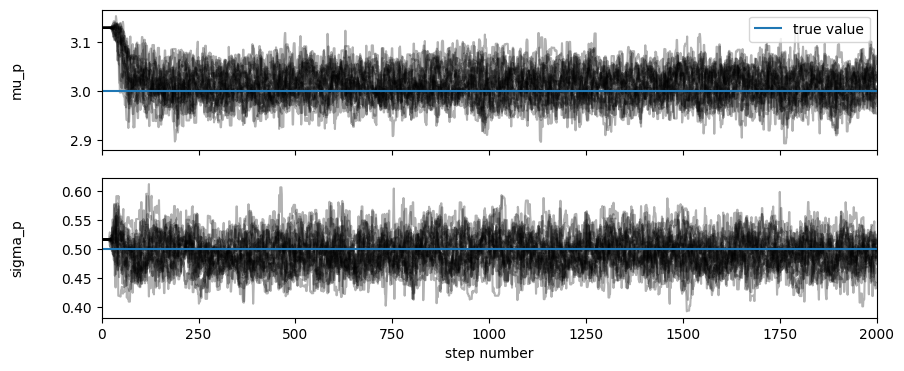

In [5]:
fig, axes = plt.subplots(2, figsize=(10, 4), sharex=True)
samples = sampler.get_chain()
labels = ["mu_p", "sigma_p"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[0].hlines(true_parent_mean, 0, len(samples), label="true value")
axes[1].hlines(true_parent_scale, 0, len(samples))
axes[-1].set_xlabel("step number")
axes[0].legend()

In [6]:
tau = sampler.get_autocorr_time()
print(tau)

[37.04660475 33.02613242]


In [7]:
flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
print(flat_samples.shape)

(2600, 2)


In [8]:
np.mean(flat_samples[:,0])

3.0130954455127155

In [9]:
np.mean(flat_samples[:,1])

0.49416737250013126

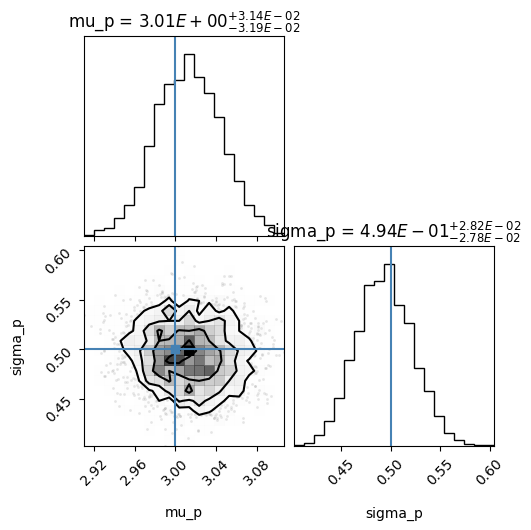

In [10]:
import corner

fig = corner.corner(
    flat_samples, labels=labels, truths=[true_parent_mean, true_parent_scale], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12}
)

# P-P plots Gaussian

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from multiprocessing import Pool
import emcee
import warnings
import corner
import pandas as pd
import bilby
warnings.filterwarnings("ignore")

In [ ]:
MU_P_LOW = 0
MU_P_HIGH = 5
SIGAM_P_LOW = 0
SIGMA_P_HIGH = 1

priors = {"mu_p": bilby.core.prior.Uniform(MU_P_LOW, MU_P_HIGH, "mu_p"), 
          "sigma_p": bilby.core.prior.Uniform(SIGAM_P_LOW, SIGMA_P_HIGH, "sigma_p")}

In [ ]:
N_obs = 500
size_child = 50
true_child_scale = 0.5

NRES = 20

RESULTS = []

In [ ]:
def log_hyperprior(params):
    parent_mean, parent_scale = params
    if (0 < parent_mean < 5 and 
        0 < parent_scale < 1):
        return 0.0
    return -np.inf

def log_likelihood(params):
    parent_mean, parent_scale = params
    return np.log(np.prod(size_child**-1 * np.sum((2 * np.pi * parent_scale**2)**-.5 * np.exp(-(true_child_gaussian - parent_mean)**2 / (2 * parent_scale**2)), axis=1)))

def log_probability(params):
    log_prior_val = log_hyperprior(params)
    if not np.isfinite(log_prior_val):
        return -np.inf
    return log_prior_val + log_likelihood(params)

100%|██████████| 1000/1000 [00:02<00:00, 428.25it/s]


Too few points to create valid contours


100%|██████████| 1000/1000 [00:01<00:00, 916.01it/s]


Too few points to create valid contours


100%|██████████| 1000/1000 [00:01<00:00, 918.10it/s]


Too few points to create valid contours


100%|██████████| 1000/1000 [00:02<00:00, 467.72it/s]
11:53 bilby INFO    : Key: KS-test p-value
11:53 bilby INFO    : mu_p: 0.24937743218434005
11:53 bilby INFO    : sigma_p: 1.876874035333163e-09
11:53 bilby INFO    : Combined p-value: 1.052290943474732e-08


(<Figure size 640x480 with 1 Axes>,
 pvals(combined_pvalue=1.052290943474732e-08, pvalues=[0.24937743218434005, 1.876874035333163e-09], names=['mu_p', 'sigma_p']))

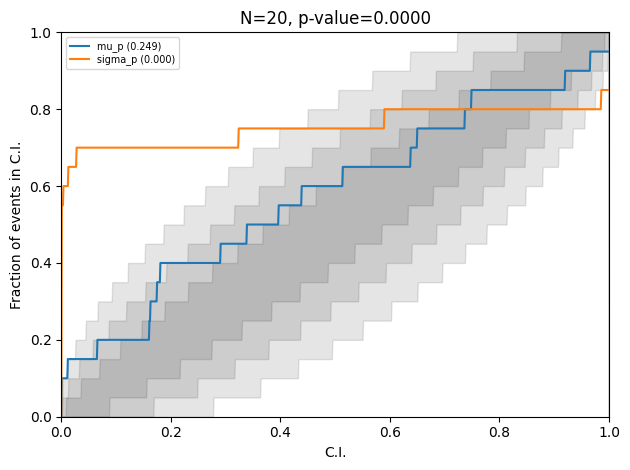

In [ ]:


for ii in range(NRES):
    injections = dict()
    posterior = dict()
    
    for key, prior in priors.items():
        injections[key] = prior.sample()
    
    true_parent_gaussian = np.random.normal(loc=injections["mu_p"], scale=injections["sigma_p"], size=N_obs)
    err_on_mean_child = np.expand_dims(np.random.randn(N_obs)*true_child_scale, axis=1)
    true_child_gaussian = np.random.normal(loc=true_parent_gaussian[:, np.newaxis] + err_on_mean_child, scale=true_child_scale, size=(N_obs, size_child))

    pos = np.array([injections["mu_p"], injections["sigma_p"]]) + 0.1 * np.random.randn(2) + 1e-6 * np.random.randn(20, 2)
    nwalkers, ndim = pos.shape

    with Pool() as pool:
        sampler = emcee.EnsembleSampler(
            nwalkers, ndim, log_probability, pool=pool,
        )
        sampler.run_mcmc(pos, 1000, progress=True)

    flat_samples = sampler.get_chain(discard=50, thin=15, flat=True)
    posterior = {"mu_p": flat_samples[:,0], "sigma_p": flat_samples[:,1]}
    
    posterior = pd.DataFrame(dict(posterior))
    posterior.to_csv(f'PP-plot-test/Single-Gaussian/samples/run{ii+1}.txt', sep='\t')
        
    result = bilby.result.Result(
        label="PPtest",
        injection_parameters=injections,
        posterior=posterior,
        search_parameter_keys=injections.keys(),
        priors=priors)
    
    RESULTS.append(result)

    fig = corner.corner(flat_samples, labels=["mu_p", "sigma_p"], truths=[injections["mu_p"], injections["sigma_p"]], title_fmt=".2E", show_titles=True, title_kwargs={'fontsize':12})
    plt.savefig('PP-plot-test/Single-Gaussian/corner-plot/run_'+str(ii+1)+'.png')
    plt.close()
        
bilby.result.make_pp_plot(RESULTS, filename=f"Single-Gaussian/PP-Plot", confidence_interval=[0.68, 0.95, 0.997])